# Homework 4, Computer Vision COMS 4731 (Due Nov. 7, 2018, 2:40 PM)

## <span style="color:red">**Name and UNI:Zhen Zhang, zz2559</span>

____________________________________
### What you need to submit:
Your submission should include this iPython notebook (titled <span style="color:red">&lt;uni&gt;.ipynb</span>, run through once before submission), `output/` (which should include `test1.png`, `test2.png`, `test3.png`, `test4a.png`, `test4b.png`, and `test5.png`), and a `part6/` directory (which should include input pictures you used for part 6, as well as the output stitched image).
_________________________________

### Guidelines
**Refer to the PDF for expected results.**

For submission, please <span style="color:red">**re-run the notebook and save once all cells are finished running**</span>. This will allow us to see your results immediately, and verify that everything works on your machine at submission time.

**You may NOT use any functions from cv2, scipy for your submission, unless specified.**

You are encouraged to use **numpy** for indexing, doing calculations, etc.

Each part will create an additional output file, in the `output` directory. Please submit these in addition to this notebook, re-run on all the cells.

In [1]:
import os

def write_output_img(filename, img):
    if not os.path.isdir("output"):
        os.mkdir("output")

    cv2.imwrite("output/" + filename, img)

___________________________
## Image Stitching

Your task is to develop a stitching algorithm that stitches a collection of photos into a mosaic. Before we create the mosaicking app, we will create the individual tools required to build it. Each tool is a separate function you need to fill out below.

## Part 1 - Compute homography (4 pt)

In this part, the goal is to develop a function to calculate and apply the homography between a pair of images. We will also develop two additional small programs to help verify whether the calculated homography is correct.

We have already implemented for you the function `compute_homography()` that calculates the homography between two sets of corresponding points in two images. Your task to implement the function `apply_homography()` that applies a homography to a set of points.

In [2]:
import numpy as np

def compute_homography(src, dst):
    # This function computes the homography from src to dst.
    #
    # Input:
    #     src: source points, shape (n, 2)
    #     dst: destination points, shape (n, 2)
    # Output:
    #     H: homography from source points to destination points, shape (3, 3)
    
    # Code here...
    
    A = np.zeros([2*src.shape[0], 9])
    for i in range(src.shape[0]):
        A[2*i, :] = np.array([src[i,0],src[i,1],1,0,0,0,
                              -dst[i,0]*src[i,0],-dst[i,0]*src[i,1],-dst[i,0]])
        A[2*i+1, :] = np.array([0,0,0,src[i,0],src[i,1],1,
                                -dst[i,1]*src[i,0],-dst[i,1]*src[i,1],-dst[i,1]])
    
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    return H

<span style="color:red">**TODO:**</span> Fill in `apply_homography` below.

In [3]:
import numpy as np

def apply_homography(src, H):
    # Applies a homography H onto the source points, src.
    #
    # Input:
    #     src: source points, shape (n, 2)
    #     H: homography from source points to destination points, shape (3, 3)
    # Output:
    #     dst: destination points, shape (n, 2)
    """ 
    n = src.shape[0]
    temp = src.transpose()
    temp = np.vstack([temp,np.ones(n)])
    res = H.dot(temp)
    print (res.shape)
    for i in range(n):
        res[0,i] /= res[2,i]
        res[1,i] /= res[2,i]
    return res[:2,:].transpose()
    """
    n = src.shape[0]
    homo_src = src.transpose()
    homo_src = np.vstack([homo_src,np.ones(n)])
    homo_dst = H.dot(homo_src)
    res = homo_dst[:2,:].copy()
    res[0,:] = np.divide(res[0,:],homo_dst[-1,:])
    res[1,:] = np.divide(res[1,:],homo_dst[-1,:])
    return res.transpose().astype('int')
    
    


**DO NOT MODIFY**: In this part, you can test your functions with the given sample testcase. You may add any other test points that you would like, but the origin test points `np.matrix('259, 505; 350, 371; 400, 675; 636, 104')` should be kept on submission.

In [4]:
# Test your functions here
# In this section, we selected four pairs of match points, we will run your function computeHomography to compute H,
# then we will use your H and another set of points to compute their matched points.
# If your implemented both functions right, you will see that the test points are connected to their matched points.
import numpy as np
import matplotlib.pyplot as plt
import cv2

src_img = cv2.imread('portrait.png')
dst_img = cv2.imread('portrait_transformed.png')
whole_img = np.concatenate((src_img, dst_img), axis=1)

src_pts = np.matrix('347, 313; 502, 341; 386, 571; 621, 508')
dst_pts = np.matrix('274, 286; 436, 305; 305, 527; 615, 506')
H = compute_homography(src_pts, dst_pts)

test_pts = np.matrix('259, 505; 350, 371; 400, 675; 636, 104')
match_pts = apply_homography(test_pts, H)

for i in range(test_pts.shape[0]):
    test_x = test_pts[i, 0]
    test_y = test_pts[i, 1]
    match_x = int(round(match_pts[i, 0] + 800))
    match_y = int(round(match_pts[i, 1]))

    cv2.line(whole_img,
        (test_x, test_y), 
        (match_x, match_y), 
        (0, 0, 255), thickness=5)
    cv2.circle(whole_img,
        (test_x, test_y),
        4, (0, 0, 255), thickness=10)
    cv2.circle(whole_img,
        (match_x, match_y),
        4, (0, 0, 255), thickness=10)

write_output_img("test1.png", whole_img)
plt.imshow(cv2.cvtColor(whole_img, cv2.COLOR_BGR2RGB))

## Part 2 - Backward Warping (8 pt)


When we map a source image to its destination image using a homography, we may encounter a problem where multiple pixels of the source image are mapped to the same point of its destination image. What's more, some pixels of the destination image may not be mapped to any pixels of source image. What should we do?

Suppose we had homography $H$, source pixel $s$ with coordinates $(x_s, y_s)$, and destination pixel $d$ with coordinates $(x_d, y_d)$. Then, $H \cdot \tilde{s} = \tilde{d}$ (where, $s$, $d$ are in homogenous space).

To deal with this problem, we consider a slight caveat, where we map the pixels of the destination image back to source image, and then use the color in the source image as its color. More precisely, for each destination pixel $d = (x_d, y_d)$, we take $H^{-1} \cdot \tilde{d}$ to obtain the coordinate of its associated source pixel, $\tilde{s}$ (from which $s$ can be found). If $s$ is within the bounds of the source image, we take the intensity of $s$ to be the intensity of $d$.

Repeating this process over the entire destination image ensures that there are no gaps in the final result. This process is called "backward warping".

<span style="color:red">**TODO:**</span> Fill in `backward_warp_img` below.

In [5]:
import numpy as np

def backward_warp_img(src_img, H, dst_img_size):
    # Input:
    #     src_img: source image, shape (m, n, 3)
    #     H: homography from destination to source image, shape (3, 3)
    #     dst_img_size: height and width of destination image, shape (2,)
    # Output:
    # dst_img: destination image, shape (dst_img_size[0], dst_img_size[1], 3)
    m = src_img.shape[0]
    n = src_img.shape[1]
    
    dst_m = dst_img_size[0]
    dst_n = dst_img_size[1]
    dst_img = np.zeros((dst_m,dst_n,3))
    for i in range(dst_m):
        for j in range(dst_n):
            coor_src = apply_homography(np.array([j,i]).reshape((1,2)),H)[0]
            if 0<=coor_src[1]<m and 0<=coor_src[0]<n:               
                #dst_img[i,j,:] = src_img[int(coor_src[0]),int(coor_src[1]),:]
                dst_img[i,j,:] = src_img[coor_src[1],coor_src[0],:]
    return dst_img
            
            
    

<span style="color:red">**TODO:**</span> We're going to need a simple mask function which takes the binary mask of an input image. Fill in `binary_mask` below.

In [6]:
def binary_mask(img):
    # Input:
    #     img: source image, shape (m, n, 3)
    # Output:
    #     mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask, if img[i, j] > 0 
    #           in any of its channels, mask[i, j] = 1. Else, (if img[i, j] = 0), mask[i, j] = 0.
    
    m,n = img.shape[:2]
    mask = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            if np.any(img[i,j,:]>0):
                mask[i,j] = 1
                
    return mask
                

**DO NOT MODIFY:** This will test the homography functions from part 1, as well as `backward_warp_img` and `binary_mask`. It inserts a portrait of Van Gogh (`portrait_small.png`) into the given canvas (`Osaka.png`).

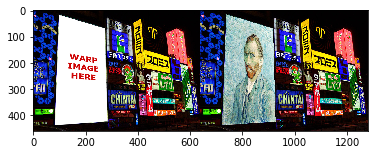

In [7]:
src_img = cv2.imread('portrait_small.png')
canvas = cv2.imread('Osaka.png')

src_pts = np.matrix('1, 1; 1, 400; 326, 1; 326, 400')
canvas_pts = np.matrix('100, 18; 84, 437; 276, 71; 286, 424')
#canvas_pts = np.matrix('18, 100; 70, 290; 340, 80; 335, 320')
H = compute_homography(src_pts, canvas_pts)
#plt.figure()
#plt.imshow(cv2.cvtColor(canvas.astype('uint8'), cv2.COLOR_BGR2RGB))
dst_img = backward_warp_img(src_img, np.linalg.inv(H), [canvas.shape[0], canvas.shape[1]])
dst_mask = 1 - binary_mask(dst_img)
dst_mask = np.stack((dst_mask,) * 3, -1)
out_img = np.multiply(canvas, dst_mask) + dst_img

warp_img = np.concatenate((canvas, out_img), axis=1)
write_output_img('test2.png', warp_img)
#plt.figure()
plt.imshow(cv2.cvtColor(warp_img.astype('uint8'), cv2.COLOR_BGR2RGB))

## Part 3 - RANSAC (8 pt)

Here, you need to implement the RANSAC algorithm to find a good homography as introduced in lecture.

The function takes two sets of matched points, $X_s$ and $X_d$ (generated by SIFT) as input, and uses RANSAC to compute the optimal homography. It returns the homography from RANSAC, as well as the indices of points from $X_s$ and $X_d$ that are detected to have very low error when transformed by the homography given by RANSAC.

Note, you need to use at least four pairs of matched points to compute a homography.

In [8]:
A = np.array([1,2,3,4,5,6])
np.argwhere(A>3)
#np.sum(A**2,axis=-1)**(1./2)

array([[3],
       [4],
       [5]])

<span style="color:red">**TODO:**</span> Fill in `RANSAC` below.

In [9]:
import numpy as np
import random



def RANSAC(Xs, Xd, max_iter, eps):
    # Input:
    #     pts1: the first set of points, shape [n, 2]
    #     pts2: the second set of points matched to the first set, shape [n, 2]
    #     max_iter: max iteration number of RANSAC
    #     eps: tolerance of RANSAC
    # Output:
    #     inliers_id: the indices of matched pairs when using the homography given by RANSAC
    #     H: the homography, shape [3, 3]
    
    
    cur_max = 0
    n = Xs.shape[0]
    for i in range(max_iter):
        pts = random.sample(range(n), 4)
        H = compute_homography(Xs[pts,:],Xd[pts,:])
        Xd_H = apply_homography(Xs,H)
        inrange_num = np.sum(np.sum((Xd-Xd_H)**2,axis=-1)<eps)
        if inrange_num>cur_max:
            cur_max = inrange_num
            H_res = H
            inliers_id = np.argwhere(np.sum((Xd-Xd_H)**2,axis=-1)<eps)
    
    inliers_id = inliers_id.reshape((len(inliers_id),))
    return [inliers_id,H_res]
        
        
       
        
        

**DO NOT MODIFY:** To ease your workload, a function `genSIFTMatchPairs` has been provided.
You may have to run: 

`sudo python3 -m pip install opencv-python==3.4.2.16`

`sudo python3 -m pip install opencv-contrib-python==3.4.2.16`

and rerun the entire notebook up to this point.

(this installs an older version of OpenCV for Python, because SIFT is no longer available in the newer OpenCV)

In [10]:
import cv2
import numpy as np

def genSIFTMatchPairs(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1 = np.zeros((250,2))
    pts2 = np.zeros((250,2))
    for i in range(250):
        pts1[i,:] = kp1[matches[i].queryIdx].pt
        pts2[i,:] = kp2[matches[i].trainIdx].pt
    
    return pts1, pts2, matches[:250], kp1, kp2

**DO NOT MODIFY:** This part tests `RANSAC`. The first figure shows the matched points using SIFT; you will see that most of the pairs are well matched, but there are outliers.

The second part uses `RANSAC`to remove the outliers. You may try different `max_iter` and `eps` values to achieve better results.

250 250


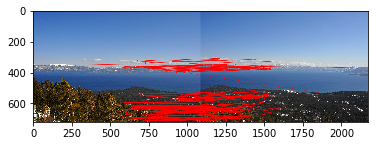

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

img1 = cv2.imread('mountain_left.png')
img2 = cv2.imread('mountain_center.png')

pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)

print (len(pts1),len(pts2))

matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2, matchColor=(0,0,255))
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

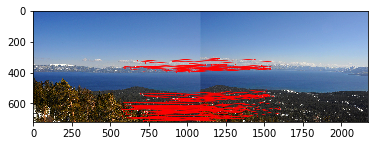

In [12]:
inliers_idx, H = RANSAC(pts1, pts2, 500, 17.5)

new_matches = []
for i in range(len(inliers_idx)):
    new_matches.append(matches[inliers_idx[i]])

matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

write_output_img("test3.png", matching_result)

## Part 4: Blending an Image Pair (4 pt)

Now, implement `blend_image_pair`, which blends two images given their binary masks.

There is also a blending mode parameter, `mode`, which can be `overlay` or `blend`. The `overlay` setting should copy `dst_img` over `src_img` wherever the `dst_img` applies. The `blend` setting should perform weighted blending as discussed in class.

You may use **scipy.ndimage.morphology.distance_transform_edt** to compute a new weighted mask for blending.

<span style="color:red">**TODO:**</span> Fill in `blend_image_pair` below.

In [13]:
from scipy.ndimage.morphology import distance_transform_edt as euc_dist

def value_mask(mask1):
    threshold = 140
    mask1_val = euc_dist(mask1)
    mask1_val[mask1_val>threshold] = threshold
    mask1_val /= threshold
    return mask1_val

def blend_image_pair(src_img, src_mask, dst_img, dst_mask, mode):
    # Given two images and their binary masks, the two images are blended.
    # 
    # Input:
    #     src_img: First image to be blended, shape (m, n, 3)
    #     src_mask: src_img's binary mask, shape (m, n)
    #     dst_img: Second image to be blended, shape (m, n, 3)
    #     dst_mask: dst_img's binary mask, shape (m, n)
    #     mode: Blending mode, either "overlay" or "blend"
    # Output:
    #     Blended image of shape (m, n, 3)
    #return src_img
    if mode == "overlay":
        
        src_mask[np.argwhere(dst_mask>0).transpose().tolist()] = 0
        src_mask = np.stack((src_mask,) * 3, -1)
        dst_mask = np.stack((dst_mask,) * 3, -1)        
        out_img = np.multiply(dst_img, dst_mask) + np.multiply(src_img,src_mask)
        plt.imshow(out_img, cmap="gray")
    else: # mode == "blend"
        #print (src_mask.shape)
        src_mask = value_mask(src_mask)
        dst_mask = value_mask(dst_mask)
        sum_mask  = src_mask+dst_mask
        src_mask /= sum_mask
        src_mask[np.isnan(src_mask)] = 1
        dst_mask /= sum_mask
        dst_mask[np.isnan(dst_mask)] = 1
        src_mask = np.stack((src_mask,) * 3, -1)
        dst_mask = np.stack((dst_mask,) * 3, -1)        
        out_img = np.multiply(dst_img, dst_mask) + np.multiply(src_img,src_mask)
       
    return out_img.astype('uint8')
        

**DO NOT MODIFY:** Run the code below to test "overlay" on `blend_image_pair`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


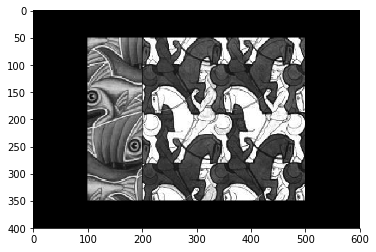

In [14]:
fish_img = cv2.imread("escher_fish.png")
horse_img = cv2.imread("escher_horsemen.png")

blend_img = blend_image_pair(fish_img, binary_mask(fish_img), horse_img, binary_mask(horse_img), "overlay")

plt.imshow(blend_img, cmap="gray")

write_output_img("test4_overlay.png", cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))

**DO NOT MODIFY:** Run the code below to test "blend" on `blend_image_pair`.

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


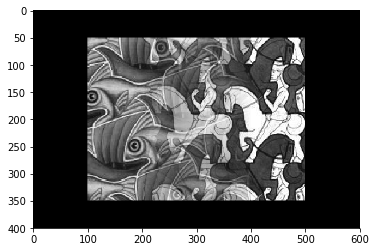

In [15]:
blend_img = blend_image_pair(fish_img, binary_mask(fish_img), horse_img, binary_mask(horse_img), "blend")

plt.imshow(blend_img)

write_output_img("test4_blend.png", cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))

## Part 5: Image Stitching (12 pt)

You now have all the tools to build the stitching app! Write a program `stitch_img` that stitches the input images into one mosaic.

Your program should accept an arbitrary number of images. You can assume the order of the input images matches the order you wish to stitch the images. Also, in this assignment we will only stitch images horizontally. Use the `blend` mode to blend the image when you call `blend_image_pair`.

**Hint: When warping multiple images on to a single base image, you may want to first compute the bounding box. This bounding box may extend beyond the size of the base image and can have negative coordinates. How would you warp the images in this case? Hint Hint: Homography needs to be updated with additional translation.**

<span style="color:red">**TODO:**</span> Fill in `stitch_img` below.

In [21]:
def stitch_img(*imgs):
    # Input:
    #     *imgs: Arbitrary number of images, each of shape (m, n, 3)
    # Output:
    #     stitched_img: image comprised of all the images stitched together, of shape (>=m, >=n, 3).
    imgs = list(imgs)
    
    
    m,n = imgs[0].shape[:2]
    num_img = len(imgs)
    
    master_img = np.zeros((m+m,n,3))
    master_img[m//2:m//2+m,:,:] = imgs[0].copy()
    master_img = master_img.astype('uint8')
    #master_img = np.vstack([imgs[0],np.zeros((m//3,n,3))])
    #master_img = np.vstack([np.zeros((m//6,n,3)),master_img])
    #plt.imshow(cv2.cvtColor(master_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    #master_img = imgs[0]
    #master_img = master_img.astype('uint8')
    ''' 
    all_coor = []
    for i in range(m):
        for j in range(n):
            all_coor.append([j,i])
    all_coor = np.array(all_coor)
    '''
     
    for img_id in range(1,num_img):
        print ("Dealing with ",img_id,"th image")
        cur_img = imgs[img_id]
        master_m,master_n = master_img.shape[:2] # master_m == m + m//3, always
        #print(master_img.shape)
        #print(cur_img.shape)
        pts_src, pts_dst, matches, kp1, kp2 = genSIFTMatchPairs(cur_img, master_img)
        inliers_idx, H = RANSAC(pts_src, pts_dst, 500, 17.5)
        next_master_img = np.zeros((master_m,master_n+n,3))
        next_master_img[:,:master_n,:] = master_img
        warped_src = backward_warp_img(cur_img, np.linalg.inv(H), np.array([master_m,master_n+n]))
        src_mask = binary_mask(warped_src)
        dst_mask = binary_mask(next_master_img)        
        next_master_img = blend_image_pair(next_master_img, dst_mask, warped_src, src_mask, "blend")
        master_img = next_master_img
        
    return master_img.astype('uint8')
    
        
    
    
   

<span style="color:red">**TODO:**</span> Run your code on the given images. You can modify the indicated line below so that `stitch_img` takes in the images in the order that you would like them to be taken.

Dealing with  1 th image


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


Dealing with  2 th image


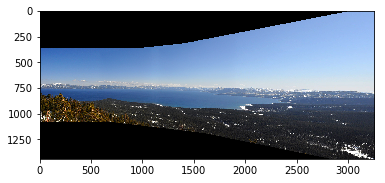

In [22]:
center_img = cv2.imread("mountain_center.png")
left_img = cv2.imread("mountain_left.png")
right_img = cv2.imread("mountain_right.png")

################### MODIFY THIS LINE ###################
final_img = stitch_img(left_img, center_img, right_img)
########################################################

plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

write_output_img("test5.png", final_img)

## Part 6: Testing your app (4 pt)

Capture **5 (or more) images** using your own camera and stitch them to create a mosaic. Note that the mosaic need not be a horizontal panorama. Submit both the captured and stitched images. When you submit, make sure you run the notebook through so we can visually check your results. Also make sure to submit the images you used, as well as the output stitched image, all inside of a folder titled `part6/`.

<span style="color:red">**TODO:**</span> Load in your own pictures, run `stitch_img`, and show your result.

Dealing with  1 th image


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


Dealing with  2 th image


/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


Dealing with  3 th image
Dealing with  4 th image


True

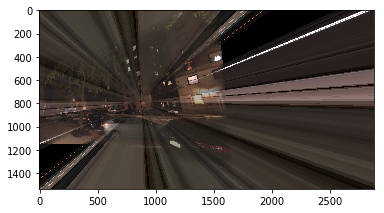

In [23]:
img_1 = cv2.imread("./part6/night1.jpg").astype('uint8')
img_2 = cv2.imread("./part6/night2.jpg").astype('uint8')
img_3 = cv2.imread("./part6/night3.jpg").astype('uint8')
img_4 = cv2.imread("./part6/night4.jpg").astype('uint8')
img_5 = cv2.imread("./part6/night5.jpg").astype('uint8')

stitched_img = stitch_img(img_1, img_2, img_3, img_4, img_5)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
cv2.imwrite("part6/stitched_night.jpg",stitched_img)

In [ ]:
img_1.shape
#cv2.imwrite("part6/stitched_room.jpg",stitched_img)